# Implementing CDFs

This notebook outlines the API for `Cdf` objects in the `empiricaldist` library, showing the implementations of many methods.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/empiricaldist/blob/master/empiricaldist/cdf_demo.ipynb).

In [ ]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import inspect

def psource(obj):
    """Prints the source code for a given object.

    obj: function or method object
    """
    print(inspect.getsource(obj))

## Constructor

For comments or questions about this section, see [this issue](https://github.com/AllenDowney/EmpyricalDistributions/issues/11).

The `Cdf` class inherits its constructor from `pd.Series`.

You can create an empty `Cdf` and then add elements.

Here's a `Cdf` that representat a four-sided die.

In [3]:
from empiricaldist import Cdf

d4 = Cdf()

In [4]:
d4[1] = 1
d4[2] = 2
d4[3] = 3
d4[4] = 4

In [5]:
d4

,probs
1,1
2,2
3,3
4,4


In a normalized `Cdf`, the last probability is 1.

`normalize` makes that true.  The return value is the total probability before normalizing.

In [6]:
psource(Cdf.normalize)

    def normalize(self):
        """Make the probabilities add up to 1 (modifies self).

        Returns: normalizing constant
        """
        total = self.ps[-1]
        self /= total
        return total



In [7]:
d4.normalize()

4

Now the Cdf is normalized.

In [8]:
d4

,probs
1,0.25
2,0.50
3,0.75
4,1.00


## Properties

For comments or questions about this section, see [this issue](https://github.com/AllenDowney/EmpyricalDistributions/issues/2).

In a `Cdf` the index contains the quantities (`qs`) and the values contain the probabilities (`ps`).

These attributes are available as properties that return arrays (same semantics as the Pandas `values` property)

In [9]:
d4.qs

array([1, 2, 3, 4])

In [10]:
d4.ps

array([0.25, 0.5 , 0.75, 1.  ])

## Sharing

For comments or questions about this section, see [this issue](https://github.com/AllenDowney/EmpyricalDistributions/issues/12).

Because `Cdf` is a `Series` you can initialize it with any type `Series.__init__` can handle.

Here's an example with a dictionary.

In [11]:
d = dict(a=1, b=2, c=3)
cdf = Cdf(d)
cdf.normalize()
cdf

,probs
a,0.333333
b,0.666667
c,1.000000


Here's an example with two lists.

In [12]:
qs = [1,2,3,4]
ps = [0.25, 0.5, 0.75, 1.0]
d4 = Cdf(ps, index=qs)
d4

,probs
1,0.25
2,0.50
3,0.75
4,1.00


You can copy a `Cdf` like this.

In [13]:
d4_copy = Cdf(d4)
d4_copy

,probs
1,0.25
2,0.50
3,0.75
4,1.00


However, you have to be careful about sharing.  In this example, the copies share the arrays:

In [14]:
d4.index is d4_copy.index

True

In [15]:
d4.ps is d4_copy.ps

True

You can avoid sharing with `copy=True`

In [16]:
d4_copy = Cdf(d4, copy=True)
d4_copy

,probs
1,0.25
2,0.50
3,0.75
4,1.00


In [17]:
d4.index is d4_copy.index

True

In [18]:
d4.ps is d4_copy.ps

False

Or by calling `copy` explicitly.

In [19]:
d4_copy = d4.copy()
d4_copy

,probs
1,0.25
2,0.50
3,0.75
4,1.00


In [20]:
d4.index is d4_copy.index

True

In [21]:
d4.ps is d4_copy.ps

False

## Displaying CDFs

For comments or questions about this section, see [this issue](https://github.com/AllenDowney/EmpyricalDistributions/issues/13).

`Cdf` provides `_repr_html_`, so it looks good when displayed in a notebook.

In [22]:
psource(Cdf._repr_html_)

    def _repr_html_(self):
        """Returns an HTML representation of the series.

        Mostly used for Jupyter notebooks.
        """
        df = pd.DataFrame(dict(probs=self))
        return df._repr_html_()



`Cdf` provides `plot`, which plots the Cdf as a line.

In [23]:
psource(Cdf.plot)

class PlotAccessor(PandasObject):
    """
    Make plots of Series or DataFrame.

    Uses the backend specified by the
    option ``plotting.backend``. By default, matplotlib is used.

    Parameters
    ----------
    data : Series or DataFrame
        The object for which the method is called.
    x : label or position, default None
        Only used if data is a DataFrame.
    y : label, position or list of label, positions, default None
        Allows plotting of one column versus another. Only used if data is a
        DataFrame.
    kind : str
        The kind of plot to produce:

        - 'line' : line plot (default)
        - 'bar' : vertical bar plot
        - 'barh' : horizontal bar plot
        - 'hist' : histogram
        - 'box' : boxplot
        - 'kde' : Kernel Density Estimation plot
        - 'density' : same as 'kde'
        - 'area' : area plot
        - 'pie' : pie plot
        - 'scatter' : scatter plot (DataFrame only)
        - 'hexbin' : hexbin plot (DataFrame

In [24]:
def decorate_dice(title):
    """Labels the axes.
    
    title: string
    """
    plt.xlabel('Outcome')
    plt.ylabel('CDF')
    plt.title(title)

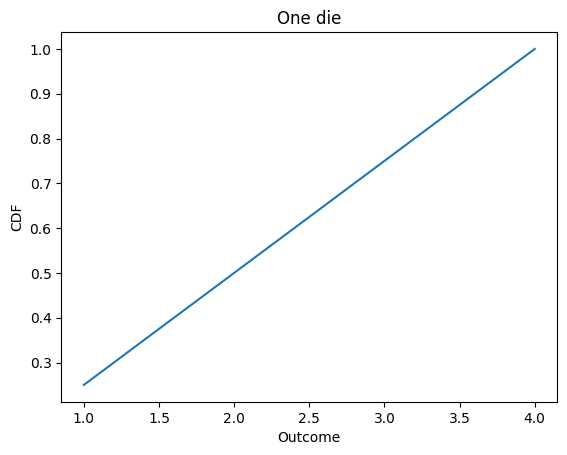

In [25]:
d4.plot()
decorate_dice('One die')

`Cdf` also provides `step`, which plots the Cdf as a step function.

In [26]:
psource(Cdf.step)

    def step(self, **options):
        """Plot the Cdf as a step function.

        Args:
        options: passed to pd.Series.plot
        """
        underride(options, drawstyle="steps-post")
        self.plot(**options)



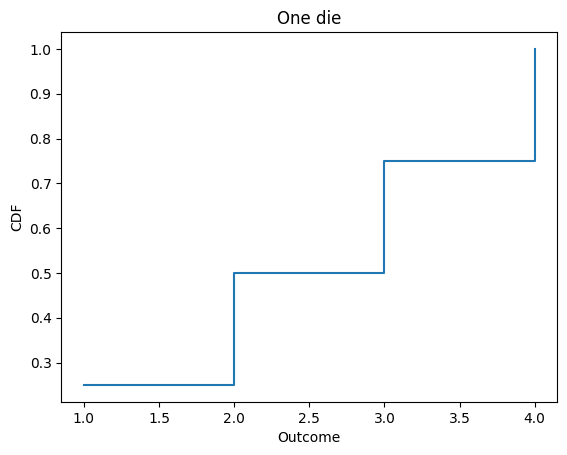

In [27]:
d4.step()
decorate_dice('One die')

## Make Cdf from sequence

For comments or questions about this section, see [this issue](https://github.com/AllenDowney/EmpyricalDistributions/issues/14).

The following function makes a `Cdf` object from a sequence of values.

In [28]:
psource(Cdf.from_seq)

    @staticmethod
    def from_seq(seq, normalize=True, sort=True, **options):
        """Make a CDF from a sequence of values.

        Args:
        seq: iterable
        normalize: whether to normalize the Cdf, default True
        sort: whether to sort the Cdf by values, default True
        options: passed to the pd.Series constructor

        Returns: CDF object
        """
        # if normalize==True, normalize AFTER making the Cdf
        # so the last element is exactly 1.0
        pmf = Pmf.from_seq(seq, normalize=False, sort=sort, **options)
        return pmf.make_cdf(normalize=normalize)



In [29]:
cdf = Cdf.from_seq(list('allen'))
cdf

,probs
a,0.2
e,0.4
l,0.8
n,1.0


In [30]:
cdf = Cdf.from_seq(np.array([1, 2, 2, 3, 5]))
cdf

,probs
1,0.2
2,0.6
3,0.8
5,1.0


## Selection

For comments or questions about this section, see [this issue](https://github.com/AllenDowney/EmpyricalDistributions/issues/15).

`Cdf` inherits [] from Series, so you can look up a quantile and get its cumulative probability.

In [31]:
d4[1]

0.25

In [32]:
d4[4]

1.0

`Cdf` objects are mutable, but in general the result is not a valid Cdf.

In [33]:
d4[5] = 1.25
d4

,probs
1,0.25
2,0.50
3,0.75
4,1.00
5,1.25


In [34]:
d4.normalize()
d4

,probs
1,0.2
2,0.4
3,0.6
4,0.8
5,1.0


## Evaluating CDFs

For comments or questions about this section, see [this issue](https://github.com/AllenDowney/EmpyricalDistributions/issues/16).

Evaluating a `Cdf` forward maps from a quantity to its cumulative probability.

In [35]:
d6 = Cdf.from_seq([1,2,3,4,5,6])

In [36]:
d6.forward(3)

array(0.5)

`forward` interpolates, so it works for quantities that are not in the distribution.

In [37]:
d6.forward(3.5)

array(0.5)

In [38]:
d6.forward(0)

array(0.)

In [39]:
d6.forward(7)

array(1.)

`__call__` is a synonym for `forward`, so you can call the `Cdf` like a function (which it is).

In [40]:
d6(1.5)

array(0.16666667)

`forward` can take an array of quantities, too.

In [41]:
def decorate_cdf(title):
    """Labels the axes.
    
    title: string
    """
    plt.xlabel('Quantity')
    plt.ylabel('CDF')
    plt.title(title)

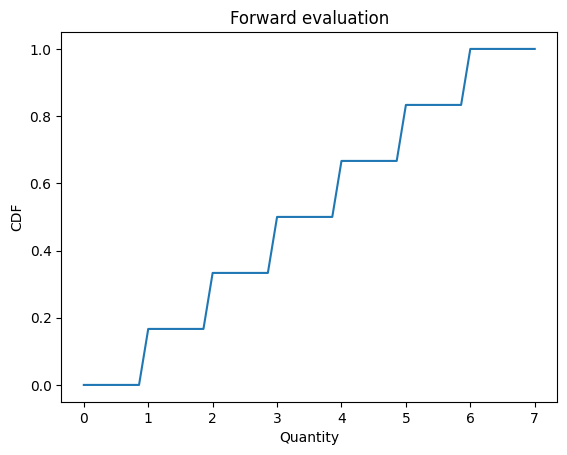

In [42]:
qs = np.linspace(0, 7)
ps = d6(qs)
plt.plot(qs, ps)
decorate_cdf('Forward evaluation')

`Cdf` also provides `inverse`, which computes the inverse `Cdf`:

In [43]:
d6.inverse(0.5)

array(3.)

`quantile` is a synonym for `inverse`

In [44]:
d6.quantile(0.5)

array(3.)

`inverse` and `quantile` work with arrays 

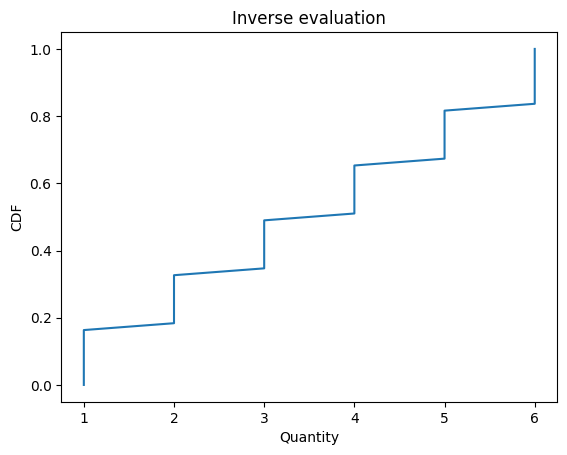

In [45]:
ps = np.linspace(0, 1)
qs = d6.quantile(ps)
plt.plot(qs, ps)
decorate_cdf('Inverse evaluation')

These functions provide a simple way to make a Q-Q plot.

Here are two samples from the same distribution.

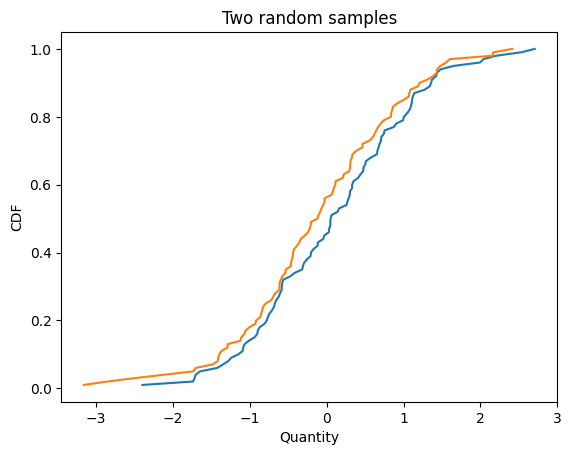

In [46]:
cdf1 = Cdf.from_seq(np.random.normal(size=100))
cdf2 = Cdf.from_seq(np.random.normal(size=100))

cdf1.plot()
cdf2.plot()
decorate_cdf('Two random samples')

Here's how we compute the Q-Q plot.

In [47]:
def qq_plot(cdf1, cdf2):
    """Compute results for a Q-Q plot.
    
    Evaluates the inverse Cdfs for a 
    range of cumulative probabilities.
    
    cdf1: Cdf
    cdf2: Cdf
    
    Returns: tuple of arrays
    """
    ps = np.linspace(0, 1)
    q1 = cdf1.quantile(ps)
    q2 = cdf2.quantile(ps)
    return q1, q2

The result is near the identity line, which suggests that the samples are from the same distribution.

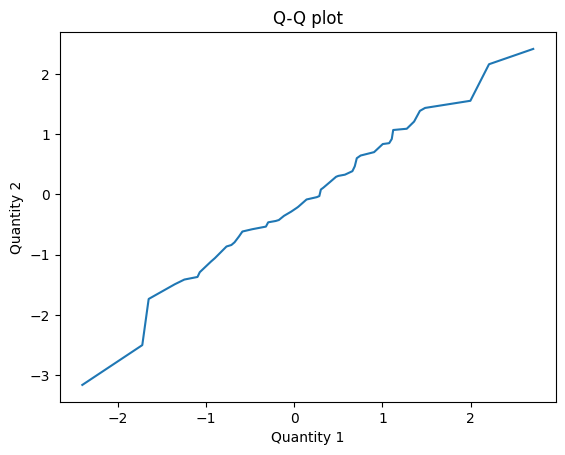

In [48]:
q1, q2 = qq_plot(cdf1, cdf2)
plt.plot(q1, q2)
plt.xlabel('Quantity 1')
plt.ylabel('Quantity 2')
plt.title('Q-Q plot');

Here's how we compute a P-P plot

In [49]:
def pp_plot(cdf1, cdf2):
    """Compute results for a P-P plot.
    
    Evaluates the Cdfs for all quantities in either Cdf.
    
    cdf1: Cdf
    cdf2: Cdf
    
    Returns: tuple of arrays
    """
    qs = cdf1.index.union(cdf2)
    p1 = cdf1(qs)
    p2 = cdf2(qs)
    return p1, p2

And here's what it looks like.

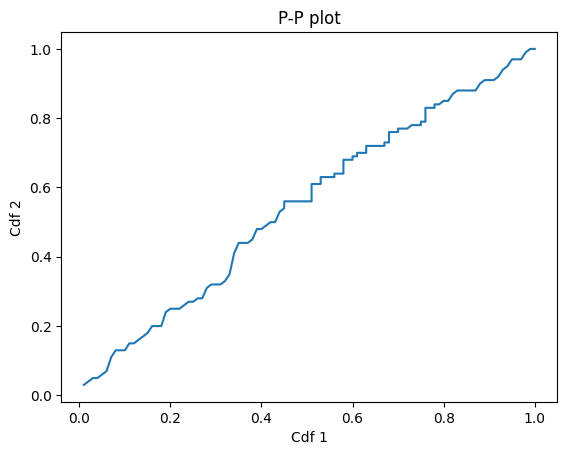

In [50]:
p1, p2 = pp_plot(cdf1, cdf2)
plt.plot(p1, p2)
plt.xlabel('Cdf 1')
plt.ylabel('Cdf 2')
plt.title('P-P plot');

## Statistics

For comments or questions about this section, see [this issue](https://github.com/AllenDowney/EmpyricalDistributions/issues/17).

`Cdf` overrides the statistics methods to compute `mean`, `median`, etc.

In [51]:
psource(Cdf.mean)

    def mean(self):
        """Expected value.

        Returns: float
        """
        return self.make_pmf().mean()



In [52]:
d6.mean()

3.5

In [53]:
psource(Cdf.var)

    def var(self):
        """Variance.

        Returns: float
        """
        return self.make_pmf().var()



In [54]:
d6.var()

2.916666666666667

In [55]:
psource(Cdf.std)

    def std(self):
        """Standard deviation.

        Returns: float
        """
        return self.make_pmf().std()



In [56]:
d6.std()

1.7078251276599332

## Sampling

For comments or questions about this section, see [this issue](https://github.com/AllenDowney/EmpyricalDistributions/issues/18).

`choice` chooses a random values from the Cdf, following the API of `np.random.choice`

In [57]:
psource(Cdf.choice)

    def choice(self, *args, **kwargs):
        """Makes a random sample.

        Uses the probabilities as weights unless `p` is provided.

        Args:
        args: same as np.random.choice
        options: same as np.random.choice

        Returns: NumPy array
        """
        pmf = self.make_pmf()
        return pmf.choice(*args, **kwargs)



In [58]:
d6.choice(size=10)

array([6, 4, 4, 2, 5, 1, 5, 2, 6, 2])

`sample` chooses a random values from the `Cdf`, following the API of `pd.Series.sample`

In [59]:
psource(Cdf.sample)

    def sample(self, n=1):
        """Samples with replacement using probabilities as weights.

        Args:
        n: number of values

        Returns: NumPy array
        """
        ps = np.random.random(n)
        return self.inverse(ps)



In [60]:
d6.sample(n=10)

array([5., 3., 4., 5., 4., 6., 5., 3., 2., 5.])

## Arithmetic

For comments or questions about this section, see [this issue](https://github.com/AllenDowney/EmpyricalDistributions/issues/9).

`Cdf` provides `add_dist`, which computes the distribution of the sum.

The implementation uses outer products to compute the convolution of the two distributions.

In [61]:
psource(Cdf.add_dist)

    def add_dist(self, x):
        """Distribution of the sum of values drawn from self and x.

        Args:
        x: Distribution, scalar, or sequence

        Returns: new Distribution, same subtype as self
        """
        pmf = self.make_pmf()
        res = pmf.add_dist(x)
        return self.make_same(res)



In [62]:
psource(Cdf.make_same)

    def make_same(self, dist):
        """Convert the given dist to Cdf.

        Args:
        dist: Distribution

        Returns: Cdf
        """
        return dist.make_cdf()



Here's the distribution of the sum of two dice.

In [63]:
d6 = Cdf.from_seq([1,2,3,4,5,6])

twice = d6.add_dist(d6)
twice

,probs
2,0.027778
3,0.083333
4,0.166667
5,0.277778
6,0.416667
7,0.583333
8,0.722222
9,0.833333
10,0.916667
11,0.972222


7.000000000000002

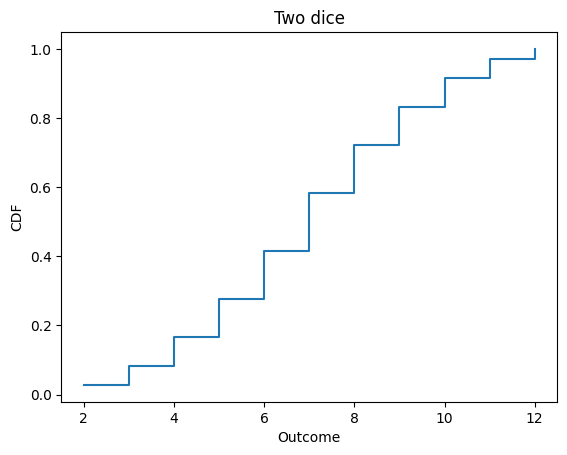

In [64]:
twice.step()
decorate_dice('Two dice')
twice.mean()

To add a constant to a distribution, you could construct a deterministic `Pmf`

In [65]:
const = Cdf.from_seq([1])
d6.add_dist(const)

,probs
2,0.166667
3,0.333333
4,0.500000
5,0.666667
6,0.833333
7,1.000000


But `add_dist` also handles constants as a special case:

In [66]:
d6.add_dist(1)

,probs
2,0.166667
3,0.333333
4,0.500000
5,0.666667
6,0.833333
7,1.000000


Other arithmetic operations are also implemented

In [67]:
d4 = Cdf.from_seq([1,2,3,4])
d6.sub_dist(d4)

,probs
-3,0.041667
-2,0.125000
-1,0.250000
0,0.416667
1,0.583333
2,0.750000
3,0.875000
4,0.958333
5,1.000000


In [68]:
d4.mul_dist(d4)

,probs
1,0.0625
2,0.1875
3,0.3125
4,0.5000
6,0.6250
8,0.7500
9,0.8125
12,0.9375
16,1.0000


In [69]:
d4.div_dist(d4)

,probs
0.250000,0.0625
0.333333,0.1250
0.500000,0.2500
0.666667,0.3125
0.750000,0.3750
1.000000,0.6250
1.333333,0.6875
1.500000,0.7500
2.000000,0.8750
3.000000,0.9375


### Comparison operators

`Pmf` implements comparison operators that return probabilities.

You can compare a `Pmf` to a scalar:

In [70]:
d6.lt_dist(3)

0.3333333333333333

In [71]:
d4.ge_dist(2)

0.75

Or compare `Pmf` objects:

In [72]:
d4.gt_dist(d6)

0.25

In [73]:
d6.le_dist(d4)

0.41666666666666663

In [74]:
d4.eq_dist(d6)

0.16666666666666666

Interestingly, this way of comparing distributions is [nontransitive]().

In [75]:
A = Cdf.from_seq([2, 2, 4, 4, 9, 9])
B = Cdf.from_seq([1, 1, 6, 6, 8, 8])
C = Cdf.from_seq([3, 3, 5, 5, 7, 7])

In [76]:
A.gt_dist(B)

0.5555555555555556

In [77]:
B.gt_dist(C)

0.5555555555555556

In [78]:
C.gt_dist(A)

0.5555555555555556

Copyright 2019 Allen Downey

BSD 3-clause license: https://opensource.org/licenses/BSD-3-Clause